## Neural Network with PyTorch

Neural network classification with pytorch

Classiffication is a problem of predicting whether something is one thing or another(there can be multiple things as the options).

### making classification data

In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000,
                    noise =0.02,
                    random_state=23)

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
X[:5]

array([[ 0.77368753,  0.17643725],
       [-0.39111301, -0.68324422],
       [-0.87415753,  0.49499196],
       [ 0.76286809,  0.26163527],
       [ 0.79902443, -0.2089095 ]])

In [ ]:
y[:5]

array([1, 1, 0, 1, 1])

In [ ]:
X.dtype, type(X)

(dtype('float64'), numpy.ndarray)

In [ ]:
X[:,1][:5]

array([ 0.17643725, -0.68324422,  0.49499196,  0.26163527, -0.2089095 ])

In [ ]:
# converting above data into dataframe

import pandas as pd
circles = pd.DataFrame({"col1" : X[:,0], "col2" : X[:,1], "label" : y})

In [ ]:
circles

,col1,col2,label
0,0.773688,0.176437,1
1,-0.391113,-0.683244,1
2,-0.874158,0.494992,0
3,0.762868,0.261635,1
4,0.799024,-0.208910,1
...,...,...,...
995,0.628165,-0.485101,1
996,0.806146,-0.299862,1
997,0.870439,0.483375,0
998,-0.797204,0.102042,1


In [ ]:
circles.shape

(1000, 3)

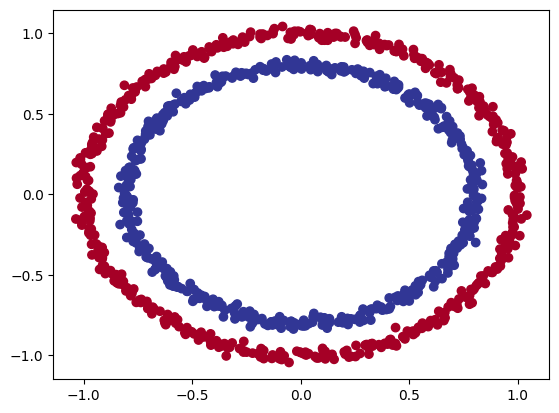

In [ ]:
# visualization
import matplotlib.pyplot as plt
plt.scatter(x = circles["col1"],
            y = circles["col2"],
            c=y, cmap = plt.cm.RdYlBu)
plt.show()

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

### Turn data into tensors and do train test split

In [ ]:
import torch
torch.__version__

'2.4.1+cu121'

In [ ]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [ ]:
X[:5] # now its in tensor

tensor([[ 0.7737,  0.1764],
        [-0.3911, -0.6832],
        [-0.8742,  0.4950],
        [ 0.7629,  0.2616],
        [ 0.7990, -0.2089]])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

### Building a model

lets's build a model to classify our red dots and blue dots

steps we need to follow:
1. setup device agnostic code so our model can use the GPU
2. Construct a model(by subclassing nn.module)
3. Define a loss fucntion and optimizer
4. Create a train and test loop

In [ ]:
# setup device agnostic code
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Now lets construct a model class

class circle(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # input layer
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # hidden layer

  def forward(self, x):
    return self.layer_2(self.layer_1(x))


In [ ]:
# instatiate the model and send it to the target device
model = circle().to(device)
model

circle(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cpu'

In [ ]:
# lets replicate the above model using nn.Sequenctial()
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [ ]:
model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6418,  0.5063],
                      [-0.5470,  0.3467],
                      [-0.6249, -0.4316],
                      [ 0.2853, -0.7039],
                      [ 0.4799,  0.4528]])),
             ('0.bias', tensor([-0.2796, -0.5040, -0.4024,  0.3200, -0.3425])),
             ('1.weight',
              tensor([[ 0.2612, -0.0959, -0.2224,  0.3130,  0.4153]])),
             ('1.bias', tensor([0.0389]))])

In [ ]:
# total_trainable_parameters = 2x5, 5 bias, 5x1, 1 bias => 10+5+5+1 => 21
total_params = sum(
	param.numel() for param in model.parameters()
)
total_params

21

## setup loss function and optimizer

Which loss function and optimizer should you use?

again this is problem specific

For example you might want to use MAE or MSE (mean absolute error or mean squared error)

For classification you might want binary cross entropy or categorical cross entropy(cross entropy).

As a reminder loss function measures how wrong your model's predictions are?

And for optimizer two of the most commmon and useful are SGD and Adam, however PyTorch has many builtin options.

In [ ]:
# loss_fc = nn.BCELoss() # requires previous sigmoid function
loss_fc = nn.BCEWithLogitsLoss() # have builtin sigmoid function

optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.001)

In [ ]:
# let calculate the accuracy: out of 100 predictions is 90 is correctly predicted then the accuracy is 90%
def accuracy_fc(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### Train the model
To train the model we need  training loop with following steps:
1. forward pass
2. calculate the loss
3. optimizer zero grad
4. loss backword (backpropagation)
5. optimizer step (gradient descent)


### going from raw logits -> predicting probabilities -> predicting labels

In [ ]:
# view the first 5 output of forward pass on the test data
model.eval()
with torch.inference_mode():
  y_logits = model(X_test.to(device))[:5]

y_logits

tensor([[-0.0572],
        [-0.2875],
        [ 0.1272],
        [-0.1911],
        [-0.0814]])

In [ ]:
# using the sigmoid activation function on model's logits to turn them into probability predictions.
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4857],
        [0.4286],
        [0.5318],
        [0.4524],
        [0.4796]])

### for our prediction probabilty values we need to perform range-style on them

- `y_pred_probs` >=0.5 , `y=1` (class 1)
- `y_pred_probs` < 0.5 , `y=0` (class 0)

In [ ]:
# find the predicted lables
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device)[:5])))

# check the equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 0.])

### Building a training and testing loop

In [ ]:
torch.manual_seed(23)
torch.cuda.manual_seed(23)

epochs = 100

# put the data to target variables
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# building a training and evaluation loop

for epoch in range(epochs):

  model.train()

  # forward pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss/accuarcy
  loss = loss_fc(y_logits, y_train)
  accuracy = accuracy_fc(y_true=y_train, y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # backpropagation
  loss.backward()

  # optimizer step (perform gradient descent)
  optimizer.step()

  # testing
  model.eval()
  with torch.inference_mode():

    # forward pass
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate the loss/accuarcy
    test_loss = loss_fc(test_logits, y_test)
    test_accuracy = accuracy_fc(y_true=y_test, y_pred=test_pred)


# lets print out what is happening

  if epoch % 10 == 0:

    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {accuracy:.2f}% | Test Loss: {test_loss:.5f} | Test_acc: {test_accuracy:.2f}%")



Epoch: 0 | Loss: 0.70301 | Acc: 49.38% | Test Loss: 0.68700 | Test_acc: 55.00%
Epoch: 10 | Loss: 0.70295 | Acc: 49.38% | Test Loss: 0.68702 | Test_acc: 55.00%
Epoch: 20 | Loss: 0.70290 | Acc: 49.50% | Test Loss: 0.68704 | Test_acc: 54.50%
Epoch: 30 | Loss: 0.70285 | Acc: 49.50% | Test Loss: 0.68706 | Test_acc: 54.50%
Epoch: 40 | Loss: 0.70280 | Acc: 49.62% | Test Loss: 0.68709 | Test_acc: 53.50%
Epoch: 50 | Loss: 0.70274 | Acc: 49.75% | Test Loss: 0.68711 | Test_acc: 53.50%
Epoch: 60 | Loss: 0.70269 | Acc: 49.75% | Test Loss: 0.68713 | Test_acc: 53.50%
Epoch: 70 | Loss: 0.70264 | Acc: 49.75% | Test Loss: 0.68716 | Test_acc: 53.50%
Epoch: 80 | Loss: 0.70259 | Acc: 49.75% | Test Loss: 0.68718 | Test_acc: 53.50%
Epoch: 90 | Loss: 0.70254 | Acc: 49.75% | Test Loss: 0.68720 | Test_acc: 53.50%


In [ ]:
from matplotlib.colors import ListedColormap
import numpy as np

In [ ]:
# Step 1: Create a meshgrid for the input space
def plot_decision_boundary(model, X, y, resolution=0.02, device='cpu'):
    # Define bounds of the domain
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Flatten the grid to pass into the model for prediction
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Step 2: Convert grid to tensor and move to the same device as the model
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)  # Move grid to the same device as the model
        logits = model(grid_tensor)  # Forward pass through the model
        predictions = torch.round(torch.sigmoid(logits)).cpu().numpy()  # Move predictions back to CPU if necessary

    # Step 3: Reshape predictions back into the shape of the meshgrid
    Z = predictions.reshape(xx.shape)

    # Step 4: Plot the contour and training points
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])  # Colors for the decision boundary
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])  # Colors for the points

    plt.contourf(xx, yy, Z, cmap=cmap_light)  # Plot decision boundary

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title('Decision Boundary')
    plt.show()


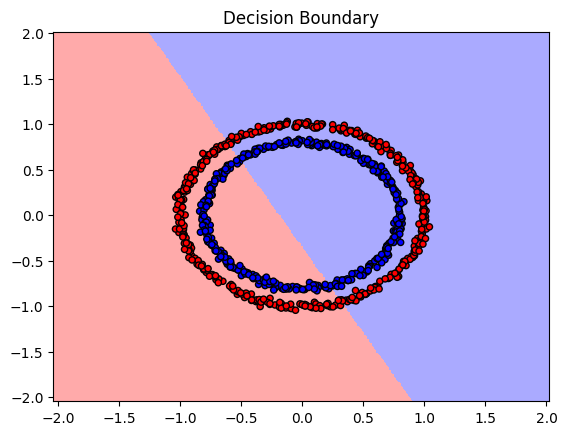

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the same device
model.to(device)

# Convert `X_train` and `y_train` to NumPy arrays if they are tensors
X_train_np = X_train.cpu().numpy() if isinstance(X_train, torch.Tensor) else X_train
y_train_np = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train

# Call the function to plot decision boundary
plot_decision_boundary(model, X_train_np, y_train_np, device=device)

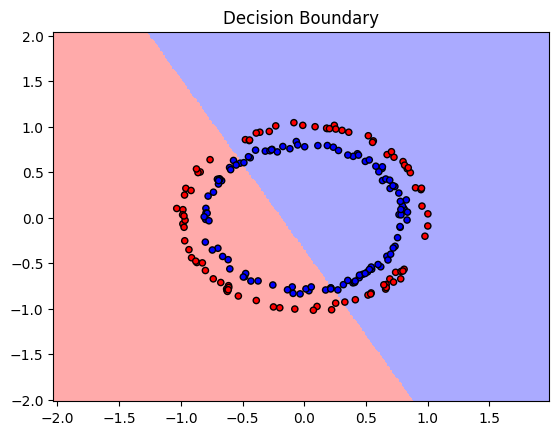

In [ ]:
X_test_np = X_test.cpu().numpy() if isinstance(X_test, torch.Tensor) else X_test
y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# Call the function to plot decision boundary
plot_decision_boundary(model, X_test_np, y_test_np, device=device)

## improving a model (from a model's perspective)

- Add more layers - Give the model more chances to learn about patterns in the data.
- Add more hidden units - like going from 5 hidden units to 10 hidden units
- Fit for longer - means more epochs
- changing the activation function
- change the learning rate
- change the loss function

### preparing the data and lets see our model can fit the straight line?
- one way to test the larger problem is to test out model on a smaller problem

In [ ]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

# create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

In [ ]:
len(X_regression), X_regression[:5], y_regression[:5]

(100,
 tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, shuffle=False)

In [ ]:
len(X_train_reg), len(X_test_reg)

(80, 20)

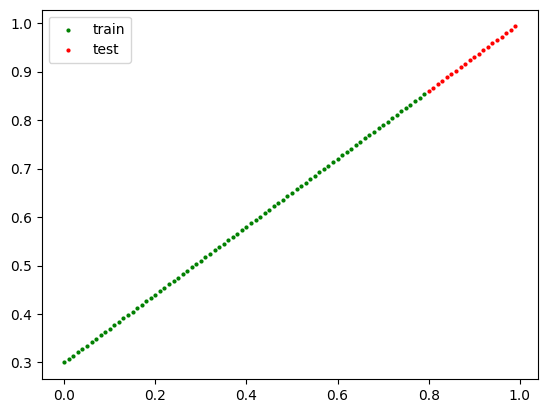

In [ ]:
plt.scatter(x=X_train_reg, y=y_train_reg, c="g",s=4, label="train")
plt.scatter(x=X_test_reg, y=y_test_reg, c="r", s=4, label="test")
plt.legend()
plt.show()

## Adjusting model to fit the straight line

In [ ]:
model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_1 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [ ]:
model_1

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fc = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.01)

In [ ]:
# train the model
torch.manual_seed(23)
torch.cuda.manual_seed(23)

epochs = 1000

X_train_reg = X_train_reg.to(device)
X_test_reg = X_test_reg.to(device)
y_train_reg = y_train_reg.to(device)
y_test_reg = y_test_reg.to(device)

# training
for epoch in range(epochs):

  model.train()
  y_pred = model_1(X_train_reg)
  loss = loss_fc(y_pred, y_train_reg)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # testing

  model.eval()
  with torch.inference_mode():

    test_pred = model_1(X_test_reg)
    test_loss = loss_fc(test_pred, y_test_reg)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test_loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.31485 | Test_loss: 0.51226
Epoch: 100 | Loss: 0.03113 | Test_loss: 0.00444
Epoch: 200 | Loss: 0.03049 | Test_loss: 0.00298
Epoch: 300 | Loss: 0.02581 | Test_loss: 0.00529
Epoch: 400 | Loss: 0.02386 | Test_loss: 0.00555
Epoch: 500 | Loss: 0.02430 | Test_loss: 0.00476
Epoch: 600 | Loss: 0.02379 | Test_loss: 0.00457
Epoch: 700 | Loss: 0.02417 | Test_loss: 0.00499
Epoch: 800 | Loss: 0.02292 | Test_loss: 0.00451
Epoch: 900 | Loss: 0.02145 | Test_loss: 0.00400


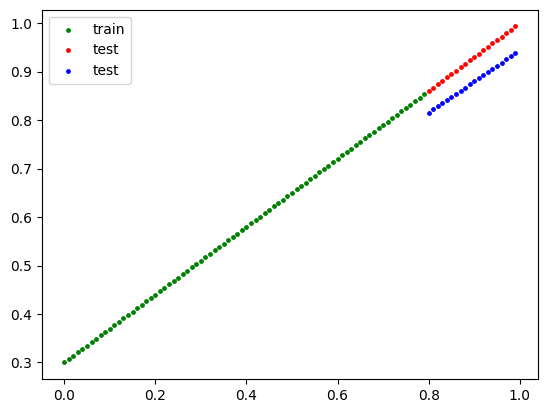

In [ ]:
plt.scatter(x=X_train_reg.cpu(), y=y_train_reg.cpu(), c="g",s=6, label="train")
plt.scatter(x=X_test_reg.cpu(), y=y_test_reg.cpu(), c="r", s=6, label="test")
plt.scatter(X_test_reg.cpu().numpy(), test_pred.cpu().numpy() , c="b", s=6, label="test")
plt.legend()
plt.show()

## Recreating the Non-Linear Data

In [ ]:
X, y = make_circles(n_samples=1000,
                    noise = 0.03,
                    random_state=42)

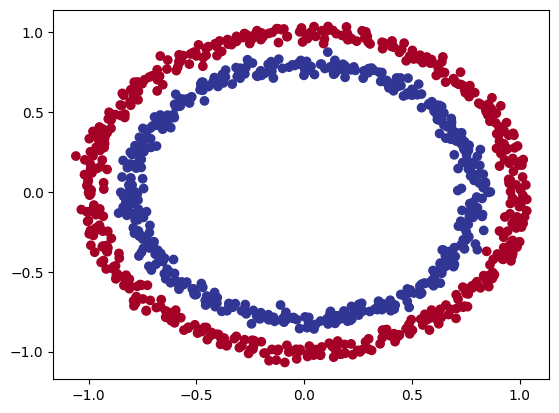

In [ ]:
plt.scatter(x=X[:,0], y=X[:,1], c= y, cmap=plt.cm.RdYlBu)

In [ ]:
# converting the data into tensors and then split the data

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Building the model with Non-Linearity
- Linear - Straight Line
- Non-Linear - Non-Straight lines

In [ ]:
## Building a model with non-linear activation fufnctions

class circleModelN(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=5)
    self.layer3 = nn.Linear(in_features=5, out_features=1)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    # return self.relu(self.layer3(self.relu(self.layer2(self.relu(self.layer1(x))))))
    x = self.relu(self.layer1(x))
    x = self.dropout(x)
    x = self.relu(self.layer2(x))
    x = self.dropout(x)
    x = self.layer3(x)
    return x

model3 = circleModelN().to(device)
model3

circleModelN(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=5, bias=True)
  (layer3): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
# setup loss fc and optimizer
loss_fc = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params = model3.parameters(),
                            lr = 0.01)

### trainning a model with non-linearity

In [1]:
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

epochs = 1000

for epoch in range(epochs):

  model3.train()

  y_logits = model3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fc(y_logits, y_train)
  accuracy = accuracy_fc(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # testing
  model3.eval()

  with torch.inference_mode():

    test_logits = model3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fc(test_logits, y_test)
    test_acc = accuracy_fc(y_test, test_pred)

  # print out what is happepnin....
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train_Loss: {loss: .5f} | Train_Acc: {accuracy: .2f}% | Test_loss: {test_loss: .5f} | Test_acc: {test_acc: .2f}%")

NameError: name 'torch' is not defined

In [ ]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

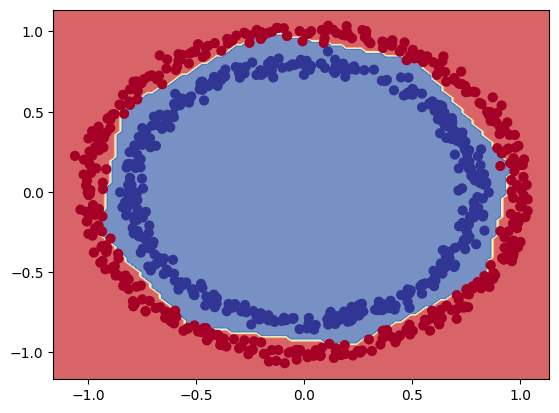

In [ ]:
# Call the function to plot decision boundary
plot_decision_boundary(model3, X_train, y_train)

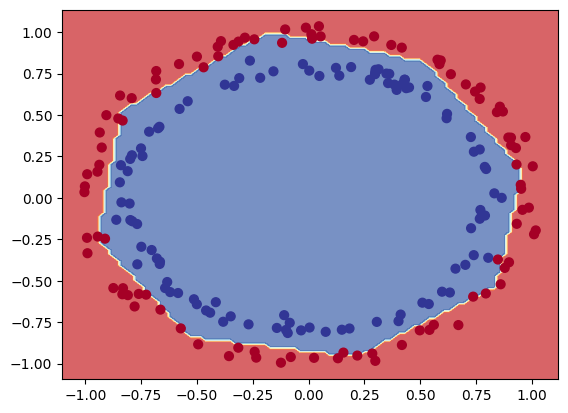

In [ ]:
plot_decision_boundary(model3, X_test, y_test)

In [ ]:
len(X_test), len(y_test)

(200, 200)

In [ ]:
X_test.shape, y_test.shape

(torch.Size([200, 2]), torch.Size([200]))

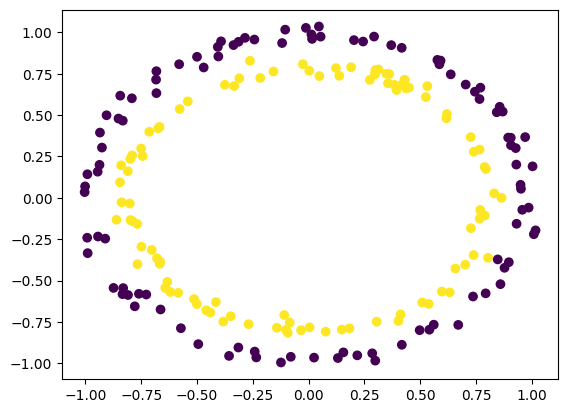

In [ ]:
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)